In [8]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close
import fastcore.all as fc
from urllib.request import urlretrieve
from tqdm import tqdm

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [9]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'


if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [10]:
with gzip.open(path_gz, 'rb') as f:
     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Initial setup

In [11]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

print(n, m)

50000 784


In [12]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [13]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [14]:
model.layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

# Cross entropy loss

In [15]:
pred.exp().sum(axis=-1, keepdim=True).shape

torch.Size([50000, 1])

In [16]:
prob = (pred.exp() / pred.exp().sum(axis=-1, keepdim=True))
prob.shape

torch.Size([50000, 10])

In [17]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [18]:
# we can use logarithm property to split division into deduction
def log_softmax(x):
    return x - x.exp().sum(-1,keepdim=True).log()

In [19]:
# denominator can be problematic because of floating numbers are not stable
# for big numbers. We can find max for each row and deduct it from other vals
def logsumexp(x):
    m = x.max(-1).values
    return m + (x-m[:,None]).exp().sum(-1).log()

In [20]:
pred.max(-1).values

tensor([0.10, 0.14, 0.21,  ..., 0.14, 0.11, 0.14], grad_fn=<MaxBackward0>)

In [21]:
def log_softmax(x):
    return x - x.logsumexp(-1,keepdim=True)

In [22]:
test_close(logsumexp(pred), pred.logsumexp(-1))
log_sm_pred = log_softmax(pred)
log_sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

# Cross entropy

In [23]:
-log_sm_pred[range(y_train.shape[0]), y_train].mean()

tensor(2.30, grad_fn=<NegBackward0>)

In [24]:
# Note that original math formula uses sum and we use mean to conrol the scale.
# Mathematically both have the same max or min and sum is just divided by a
# constant which is n-examples (targets.shape[0])
def nll(log_prob, targets):
    return -log_prob[range(targets.shape[0]), targets].mean()

loss = nll(log_sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [25]:
# Pytorch implementation
# Note that nll_loss takes as input log probabilities and cross_entropy just model outputs

test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

# Basic training loop

In [26]:
loss_func = F.cross_entropy

In [27]:
bs=500                  # batch size
lr = 0.5               # learning rate
epochs = 3             # how many epochs to train for
n = y_train.shape[0]

xb = x_train[0:bs]     # a mini-batch from x
yb = y_train[0:bs]

preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([500, 10]))

In [28]:
loss_func(preds, yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [29]:
# To get prediction for each example we can use argmax across columns
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8, 8, 3, 9, 3, 3, 9, 3, 9, 3, 3, 9, 9, 3, 8, 4, 3, 3, 9, 9, 3, 3, 9, 3, 9,
        8, 9, 9, 9, 9, 3, 9, 9, 5, 5, 3, 3, 9, 3, 3, 8, 3, 3, 9, 5, 6, 3, 5, 5, 3, 3, 9, 9, 5, 9, 9, 5, 3, 9, 4, 9, 3, 9, 9, 9, 3, 9, 5, 9,
        9, 5, 8, 9, 9, 5, 9, 9, 4, 3, 3, 8, 9, 9, 9, 9, 9, 3, 3, 9, 3, 5, 9, 9, 3, 5, 8, 9, 3, 5, 9, 5, 9, 3, 9, 9, 5, 9, 5, 5, 9, 4, 3, 9,
        9, 3, 3, 5, 3, 5, 3, 5, 3, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 5, 3, 3, 5, 5, 9, 3, 9, 5, 3, 8, 9, 3, 9, 9, 3, 3, 9, 5, 3, 5,
        9, 9, 3, 9, 5, 9, 9, 9, 9, 8, 7, 3, 3, 9, 9, 3, 5, 5, 9, 5, 3, 9, 5, 9, 9, 5, 8, 9, 3, 8, 9, 3, 3, 9, 8, 9, 9, 5, 3, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 3, 3, 3, 5, 9, 9, 9, 9, 3, 9, 9, 3, 5, 5, 8, 9, 8, 9, 9, 9, 8, 9, 3, 9, 5, 9, 9, 5, 9, 5, 9, 9, 5, 9, 9, 9, 3, 7, 8, 7,
        9, 3, 3, 9, 

In [30]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

accuracy(preds, yb)

tensor(0.11)

In [31]:
report(loss_func(preds, yb), preds, yb)

2.31, 0.11


In [32]:
model = Model(m, nh, 10)

for j in range(epochs):
    for i in tqdm(range(0, n, bs)):
        # get slice of data
        s = slice(i, min(i+bs,n))
        xb = x_train[s]
        yb = y_train[s]

        # calculate predictions, loss and gradients
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()

        # update weights of the model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, 'weight'):
                    layer.weight -= lr * layer.weight.grad
                    layer.bias -= lr * layer.bias.grad
                    layer.weight.grad.zero_()
                    layer.bias.grad.zero_()

    report(loss, pred, yb)

  3%|▎         | 3/100 [00:00<00:04, 22.30it/s]

100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


0.45, 0.88


100%|██████████| 100/100 [00:05<00:00, 19.43it/s]


0.36, 0.89


100%|██████████| 100/100 [00:04<00:00, 20.22it/s]

0.30, 0.91


In [33]:
pred.shape

torch.Size([500, 10])

# Simplify model

1) Running a few layers in a row is very common so there is a class in pytroch to simplify it, nn.Sequential
2) Rather than checking if a layer has weight attribute, we can use .parameters() method to loop over all params

In [34]:
n_out = 10 # we have 10 digit classes to predict
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,n_out))

In [35]:
for nm, module in model.named_children():
    print(f"{nm}: {module}")

0: Linear(in_features=784, out_features=50, bias=True)
1: ReLU()
2: Linear(in_features=50, out_features=10, bias=True)


In [36]:
# we have to Linear layers and each has weights and biases as parameters

for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [37]:
def fit():
    for j in range(epochs):
        for i in tqdm(range(0, n, bs)):
            s = slice(i, min(i+bs,n))
            xb = x_train[s]
            yb = y_train[s]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
        report(loss, pred, yb)

In [38]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,n_out))
fit()

100%|██████████| 100/100 [00:05<00:00, 17.23it/s]


0.45, 0.89


100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


0.37, 0.90


100%|██████████| 100/100 [00:05<00:00, 19.55it/s]

0.31, 0.91


# Refactoring weights update to the Optimizer class

In [39]:
type(model.parameters())

generator

In [40]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params) # convert a generator to a list
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_() # with .data we don't need to use no_grad context mgmt    

In [41]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,n_out))
opt = Optimizer(model.parameters(), lr=0.5)

def fit():
    for _ in range(epochs):
        for i in tqdm(range(0, n, bs)):
            s = slice(i, min(i+bs,n))
            xb, yb = x_train[s], y_train[s]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, pred, yb)

In [42]:
fit()

100%|██████████| 100/100 [00:04<00:00, 22.61it/s]


0.44, 0.88


100%|██████████| 100/100 [00:04<00:00, 22.47it/s]


0.36, 0.91


100%|██████████| 100/100 [00:08<00:00, 11.24it/s]

0.31, 0.91


# Put model and data on GPU

In [43]:
device = torch.device("cuda")
device

device(type='cuda')

In [44]:
epochs = 50

model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,n_out))
model.to(device)

opt = Optimizer(model.parameters())

def fit():
    for j in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            xb, yb = x_train[s].to(device), y_train[s].to(device)
            pred = model(xb.to(device))
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if  j % 10==0: report(loss, pred, yb)

In [45]:
fit()

0.46, 0.88
0.14, 0.96
0.08, 0.98
0.05, 0.98
0.04, 0.99


# Dataset class
we want to abstract iterating over x and y into one class. We need to define two dunder methods: len and getitem

In [46]:
class Dataset():
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y

    def __len__(self): 
        return len(self.x)

    def __getitem__(self, i):
        return (self.x[i], self.y[i])

In [47]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [48]:
epochs = 50

model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,n_out))
model.to(device)

opt = Optimizer(model.parameters())

def fit():
    for j in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            xb, yb = train_ds[s]
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if  j % 10==0: report(loss, pred, yb)

In [49]:
fit()

0.45, 0.88


0.15, 0.96
0.09, 0.98
0.06, 0.98
0.04, 0.99


# DataLoader

We want to one get read of setting up slice in the loop

In [50]:
class Dataloader:
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        self.n = len(self.ds)
    
    def __iter__(self):
        for i in range(0, self.n , bs): 
            yield self.ds[i:min(i+self.bs, self.n)]

In [51]:
dl = Dataloader(train_ds, bs)

model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,n_out)).to(device)
opt = Optimizer(model.parameters())

def fit():
    for j in range(epochs):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if  j % 10==0: report(loss, pred, yb)

In [52]:
fit()

0.46, 0.88
0.14, 0.96
0.08, 0.98
0.05, 0.99
0.03, 0.99


# Sampler

We want to now randomize the order of our observations in each epoch

In [53]:
import random
from itertools import islice

class Sampler:
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
    
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [54]:
s = Sampler(train_ds)

In [55]:
for i in s:
    print(i)
    if i == 5: break

0
1
2
3
4
5


In [56]:
list(islice(s, 8))

[0, 1, 2, 3, 4, 5, 6, 7]

In [57]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[49733, 23313, 48567, 29316, 26738]

In [58]:
fc.chunked??

Signature: fc.chunked(it, chunk_sz=None, drop_last=False, n_chunks=None)
Source:   
def chunked(it, chunk_sz=None, drop_last=False, n_chunks=None):
    "Return batches from iterator `it` of size `chunk_sz` (or return `n_chunks` total)"
    assert bool(chunk_sz) ^ bool(n_chunks)
    if n_chunks: chunk_sz = max(math.ceil(len(it)/n_chunks), 1)
    if not isinstance(it, Iterator): it = iter(it)
    while True:
        res = list(itertools.islice(it, chunk_sz))
        if res and (len(res)==chunk_sz or not drop_last): yield res
        if len(res)<chunk_sz: return
File:      /usr/local/lib/python3.10/dist-packages/fastcore/basics.py
Type:      function


In [90]:
print(list(islice(ss,5)))
print(list(islice(ss,5)))

[34703, 26589, 4507, 44615, 1778]
[41945, 42784, 47195, 12830, 30495]


In [60]:
# The basic idea of this class is that we want to be able to chunk one iterator into batches

class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [61]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[45473, 29441, 14092, 38313],
 [2768, 21879, 7814, 26986],
 [16900, 7247, 43152, 31469],
 [4375, 8172, 32649, 35095],
 [33669, 36891, 22823, 49736]]

In [62]:
from itertools import zip_longest

a = (1,2,3,4)
b = (5,6,7)

print(list(zip(a,b)))
print(list(zip_longest(a, b)))

[(1, 5), (2, 6), (3, 7)]
[(1, 5), (2, 6), (3, 7), (4, None)]


In [76]:
a = [(1,2), (3,4), (5,6), (7,8)]
x, y = zip(*a)
x, y

((1, 3, 5, 7), (2, 4, 6, 8))

In [77]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [79]:
xx = [torch.tensor(i) for i in x]
print(xx)
print(torch.stack(xx))

[tensor(1), tensor(3), tensor(5), tensor(7)]
tensor([1, 3, 5, 7])


In [80]:
# We need a new DataLoader class because recall that Dataset returns a tuple of (x, y).
# Now batch sampler gives us random indices for getting tuples of x and y and we want to 
# stack them together into just one tensor. That was not needed when we used a slice in 
# prior implementation because the slice was taking subsequent part of each tensor (x and y)

class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [81]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [82]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

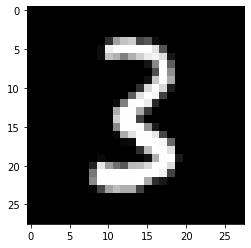

In [83]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [70]:
# 500 pictures which are 28x28 (784 pixels in total) 
# and 500 corresponding labels 

xb.shape,yb.shape

(torch.Size([500, 784]), torch.Size([500]))

In [84]:
from torch import optim

def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [85]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [86]:
model.to(device)

fit()

0.44, 0.89
0.15, 0.96
0.09, 0.98
0.06, 0.98
0.05, 0.99


# Multiprocessing DataLoader

In [91]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr